In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt

astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 384  # object size n x,y
nz = 384  # object size in z    
ntheta = 128  # number of angles (rotations)

pnz = 384 # tomography chunk size for GPU processing
ptheta = 128 # holography chunk size for GPU processing

center = n/2 # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32') # projection angles

# ID16a setup
voxelsize = 1e-6*2048/n#object voxel size
energy = 33.35  # [keV] xray energy    
focusToDetectorDistance = 128
sx0 = 0.037
z1 = np.array([0.4584,0.4765,0.5488,0.69895])-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1    
norm_magnifications = magnifications/magnifications[0]

print(f'{voxelsize=}')
print(f'{energy=}') 
print(f'{focusToDetectorDistance=}')
print(f'{sx0=}')
print(f'{z1=}')
print(f'{z2=}')
print(f'{distances=}')
print(f'{magnifications=}')    
print(f'normalized magnifications= {norm_magnifications}')

voxelsize=5.333333333333333e-06
energy=33.35
focusToDetectorDistance=128
sx0=0.037
z1=array([0.4214 , 0.4395 , 0.5118 , 0.66195])
z2=array([127.5786 , 127.5605 , 127.4882 , 127.33805])
distances=array([0.42001267, 0.43799094, 0.5097536 , 0.65852674])
magnifications=array([303.74940674, 291.24004551, 250.09769441, 193.36807916])
normalized magnifications= [1.         0.95881684 0.8233685  0.63660397]


## Read real and imaginary parts of the refractive index u = delta+i beta

In [3]:
beta0 = dxchange.read_tiff('data/beta-chip-256.tiff')
delta0 = dxchange.read_tiff('data/delta-chip-256.tiff')

pad it to the given sizes to avoid aliasing effects in data modeling and reconstruction

In [4]:
delta = np.zeros([nz,n,n],dtype='complex64')
beta = np.zeros([nz,n,n],dtype='complex64')
delta[nz//2-128:nz//2+128,n//2-128:n//2+128,n//2-128:n//2+128]= delta0
beta[nz//2-128:nz//2+128,n//2-128:n//2+128,n//2-128:n//2+128]= beta0
# delta[nz//2-128//2:nz//2+128//2,n//2-128//2:n//2+128//2,n//2-128//2:n//2+128//2]= delta0[::2,::2,::2]
# beta[nz//2-128//2:nz//2+128//2,n//2-128//2:n//2+128//2,n//2-128//2:n//2+128//2]= beta0[::2,::2,::2]


## Smooth border to avoid aliasing effects in data modeling

In [5]:
v = np.arange(-n//2,n//2)/n
[vx,vy] = np.meshgrid(v,v)
v=np.exp(-10*(vx**2+vy**2))*10
delta = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(delta))*v)))).real
beta = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(beta))*v)))).real
delta[delta>0]=0
beta[beta<0]=0

### Given delta gives phase wrapping for such acquistion parameters, therefore we decrease it:

In [6]:
delta/=10

In [7]:
u = (delta+1j*beta).astype('complex64')

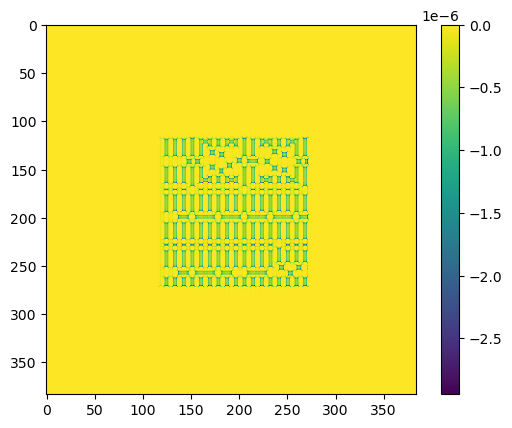

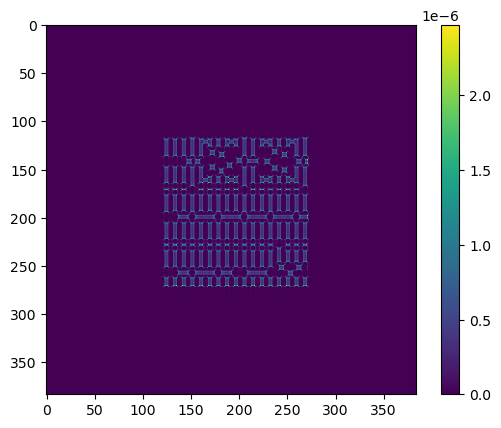

In [8]:
plt.imshow(u[49+nz//2-256//2].real);
plt.colorbar()
plt.show()
plt.imshow(u[49+nz//2-256//2].imag);
plt.colorbar()
plt.show()

Note that in this formation delta is negative

## Create a solver class for tomography

In [9]:
tslv = holotomo.SolverTomo(theta, ntheta, nz, n, pnz, center)

note pnz parameter is used to define the number of slices for simultaneous processing by 1 gpu. Currently pnz=nz. If the gpu does not have enough memory then pnz should  be decreased

## Create a solver class for holography

In [10]:
pslv = holotomo.SolverHolo(ntheta, nz, n, ptheta, voxelsize, energy, distances, norm_magnifications)

note pntheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

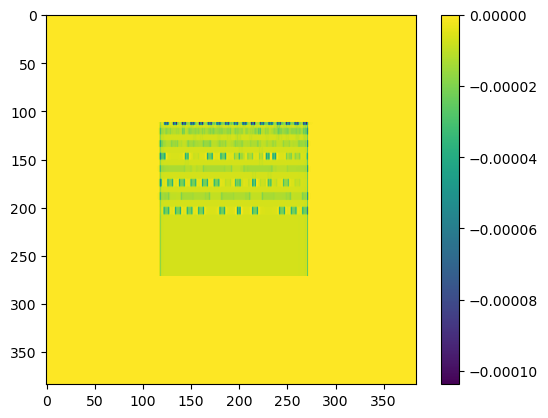

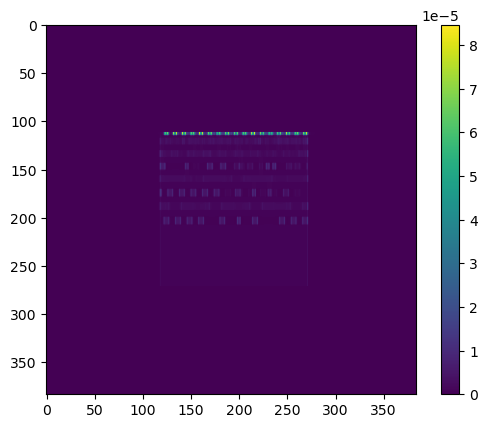

In [11]:
Ru = tslv.fwd_tomo_batch(u)
plt.imshow(Ru[0].real)
plt.colorbar()
plt.show()
plt.imshow(Ru[0].imag)
plt.colorbar()
plt.show()

## Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

In [12]:
psi = pslv.exptomo(Ru)

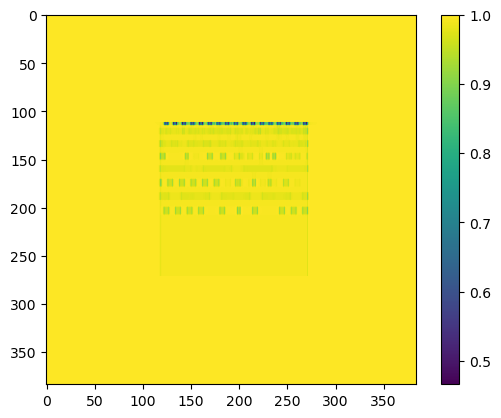

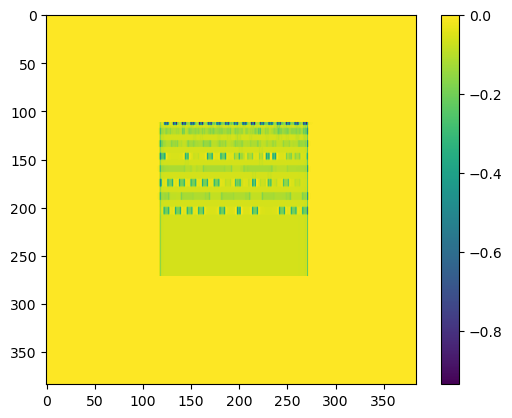

In [13]:
plt.imshow(np.abs(psi[0]))
plt.colorbar()
plt.show()
plt.imshow(np.angle(psi[0]))
plt.colorbar()
plt.show()

## Read reference images (probes) recovered by the NFP (Near-field ptychogarphy) method at ID16A. There are probes for 4 different distances.

In [14]:
prb = np.zeros([len(distances),nz,n],dtype='complex64')    
prb_abs = dxchange.read_tiff_stack('data/prb_id16a/prb_abs_00000.tiff',ind=range(len(distances)))[:,1024-n//2:1024+n//2,1024-n//2:1024+n//2]
prb_phase = dxchange.read_tiff_stack('data/prb_id16a/prb_phase_00000.tiff',ind=range(len(distances)))[:,1024-n//2:1024+n//2,1024-n//2:1024+n//2]
prb[:] = prb_abs*np.exp(1j*prb_phase)            
#prb[:] = 1

note the original reference images are 2048x2048, for this tests they are cropped

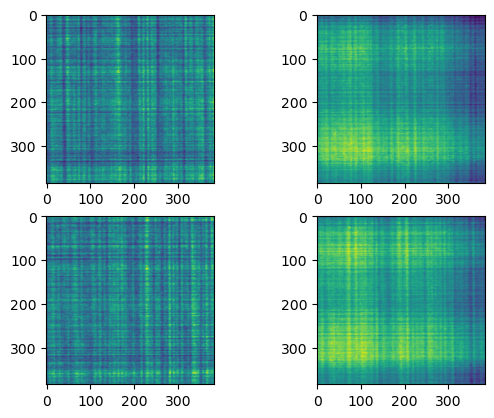

In [15]:
plt.subplot(2,2,1)
plt.imshow(np.abs(prb[0]))
plt.subplot(2,2,2)
plt.imshow(np.angle(prb[0]))
plt.subplot(2,2,3)
plt.imshow(np.abs(prb[-1]))
plt.subplot(2,2,4)
plt.imshow(np.angle(prb[-1]))
plt.show()

# Compute holographic projections for all angles and all distances

In [16]:
fpsi = pslv.fwd_holo_batch(psi,prb)

## Take squared absolute value to simulate data on the detector

In [17]:
data = np.abs(fpsi)**2

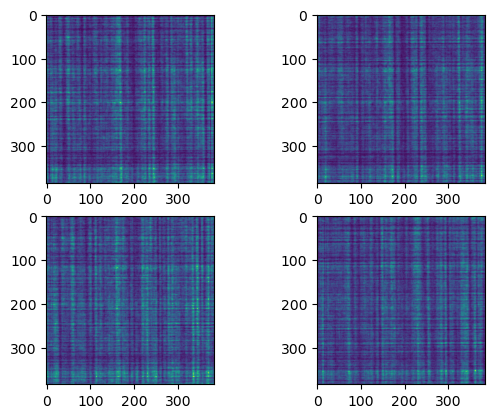

In [18]:
plt.subplot(2,2,1)
plt.imshow(data[0,0])
plt.subplot(2,2,2)
plt.imshow(data[1,0])
plt.subplot(2,2,3)
plt.imshow(data[2,0])
plt.subplot(2,2,4)
plt.imshow(data[3,0])
plt.show()

# Perform the adjoint test to check the correctnes of the adjoint operator for the iterative scheme $<\mathcal{G}^*\mathcal{G}\psi,\psi> = <\mathcal{G}\psi,\mathcal{G}\psi>$

In [19]:
psi0 = pslv.adj_holo_batch(fpsi, prb)

In [20]:
print(f'Adjoint test: {np.sum(psi*np.conj(psi0))} ? {np.sum(fpsi*np.conj(fpsi))}')        

Adjoint test: (6859095040+46.74058151245117j) ? (6859116032-0.010205994360148907j)


# Solving the problem $\sum_{k,j}\||\mathcal{G}_kq_k \psi_j|-d_{k,j}\|_2\to min$ with the Conjugate Gradient

In [21]:
piter = 64 # number of CG iters
init = psi*0+1 # initial guess
pslv = holotomo.SolverHolo(ntheta, nz, n, ptheta, voxelsize, energy, distances, norm_magnifications)
rec = pslv.cg_holo_batch(data,init,prb,piter)

Processing angles: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
0) gamma=1, err=1823333.375
1) gamma=1, err=456608.03125
2) gamma=1, err=182941.46875
3) gamma=1, err=99671.546875
4) gamma=1, err=59952.18359375
5) gamma=1, err=40459.875
6) gamma=1, err=27946.125
7) gamma=1, err=21651.13671875
8) gamma=1, err=17278.10546875
9) gamma=1, err=14764.4833984375
10) gamma=1, err=12835.3271484375
11) gamma=1, err=11570.9765625
12) gamma=1, err=10452.5751953125
13) gamma=1, err=9668.6259765625
14) gamma=1, err=8908.6904296875
15

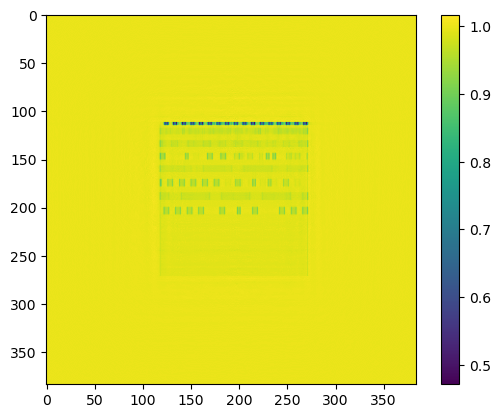

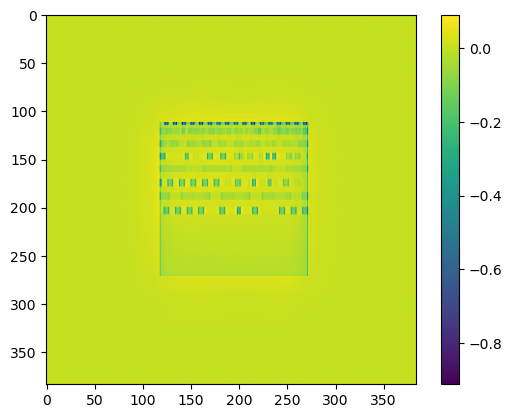

In [22]:
plt.imshow(np.abs(rec[0]))
plt.colorbar()
plt.show()
plt.imshow(np.angle(rec[0]))
plt.colorbar()
plt.show()

# Comparison to the ground truth:

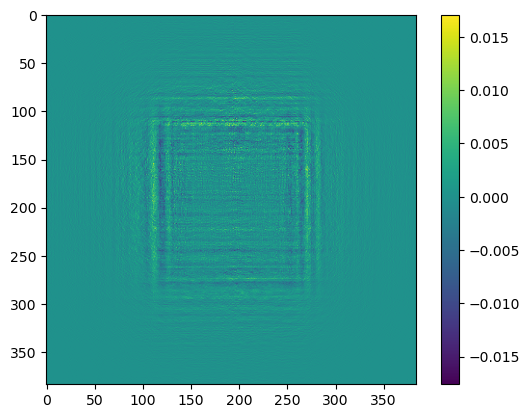

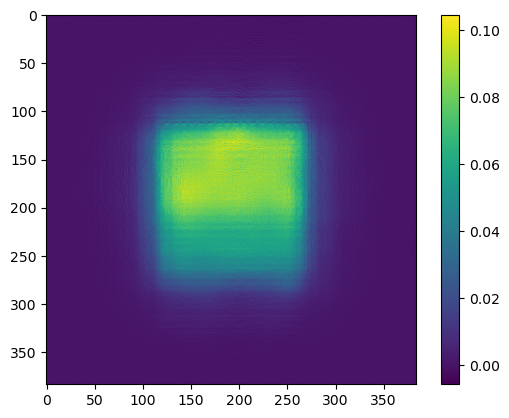

In [23]:
plt.imshow(np.abs(rec[0])-np.abs(psi[0]))
plt.colorbar()
plt.show()
plt.imshow(np.angle(rec[0])-np.angle(psi[0]))
plt.colorbar()
plt.show()

# Convert the recovered transmittance function to the complex refracive index:

In [24]:
projrec = pslv.logtomo(rec)

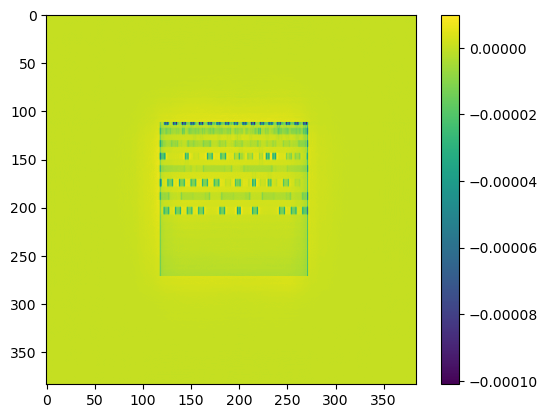

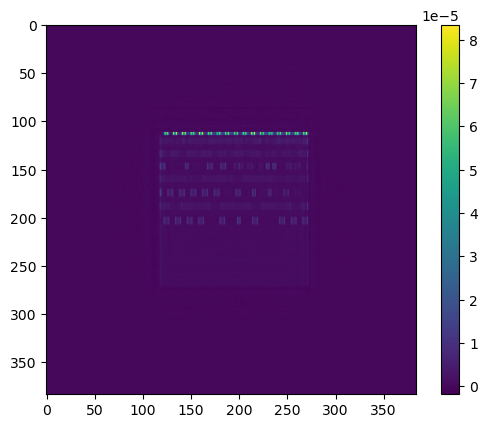

In [25]:
plt.imshow(projrec[0].real)
plt.colorbar()
plt.show()
plt.imshow(projrec[0].imag)
plt.colorbar()
plt.show()

# Solve tomogarphy problem with the Conjugate gradient solver, adding padding data and unpadding reconstruction

In [26]:
ne = n
print(np.linalg.norm(projrec))
with holotomo.SolverTomo(theta, ntheta, nz, ne, 384, center+(ne-n)/2) as tslv:
    # simulate data
    # projrec = tslv.paddata(projrec, ne)
    # cg solver
    init = np.zeros([nz,ne,ne],dtype='complex64')
    piter = 64
    urec = tslv.cg_tomo_batch(projrec,init,piter)
    # urec = tslv.unpadobject(urec, n)

0.013756068
Processing slices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238

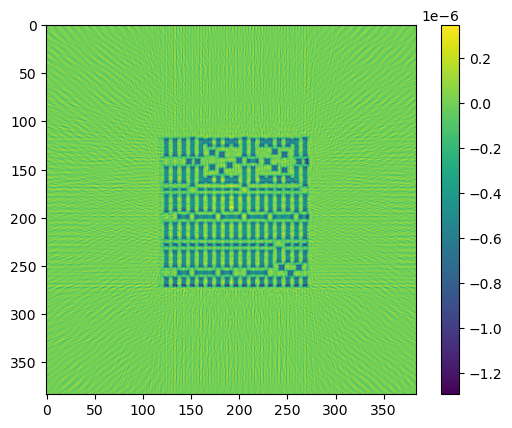

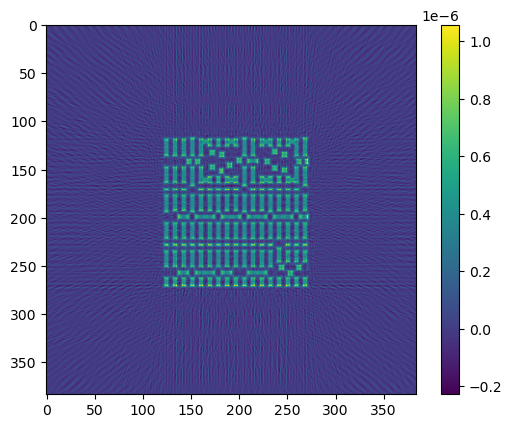

In [27]:
plt.imshow(urec[49+nz//2-256//2].real)
plt.colorbar()
plt.show()
plt.imshow(urec[49+nz//2-256//2].imag)
plt.colorbar()
plt.show()

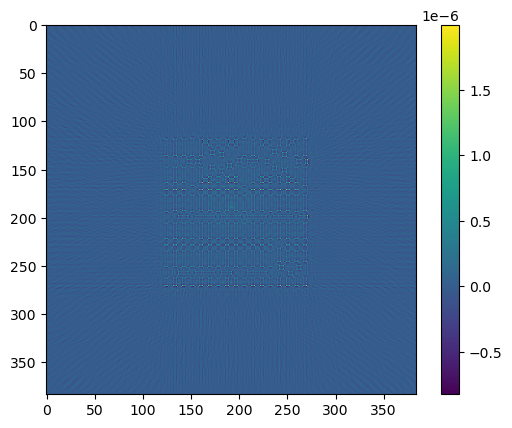

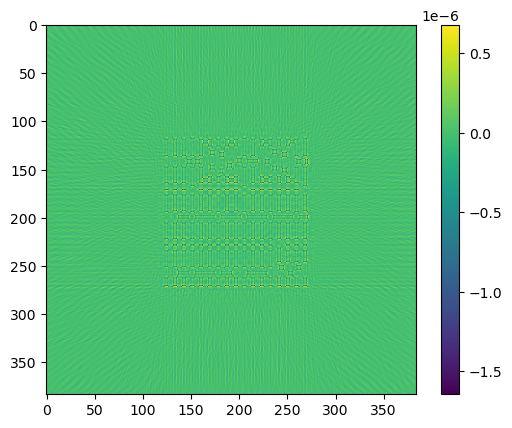

In [28]:
plt.imshow(urec[49+nz//2-256//2].real-u[49+nz//2-256//2].real)
plt.colorbar()
plt.show()
plt.imshow(urec[49+nz//2-256//2].imag-u[49+nz//2-256//2].imag)
plt.colorbar()
plt.show()